参考: https://qiita.com/sugulu_Ogawa_ISID/items/697bd03499c1de9cf082

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

print(torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

1.11.0+cu113


device(type='cuda')

In [2]:
df = pd.DataFrame.from_dict(pd.read_pickle('./data/twitter/twitterJSA_data.pickle'))
lable2idx = {0:"ポジティブ&ネガティブ",
            1:"ポジティブ",
            2:"ネガティブ",
            3:"ニュートラル",
            4:"無関係"}
lable_length = 5

# data数削減
df = df.sample(n=7000, random_state=123)
df.head

<bound method NDFrame.head of              id  topic              status            label  \
260782  1152146  10026  649586508110757888  [0, 0, 0, 0, 1]   
328485  1394459  10022  703752483483430912  [0, 0, 1, 0, 0]   
493161  2672788  10021  691170800846548992  [0, 0, 0, 1, 0]   
83628    478577  10000  668649960359878656  [0, 0, 1, 0, 0]   
57522    473962  10000  667307740990083073  [0, 0, 0, 1, 0]   
...         ...    ...                 ...              ...   
40864    457206  10000  661404228057849856  [0, 0, 0, 0, 1]   
258538  1154205  10024  460976864593326081  [0, 0, 0, 1, 0]   
15994     28434  10000  527276031233646592  [0, 0, 1, 1, 0]   
469170  2152918  10025  699154791004409856  [0, 0, 0, 1, 0]   
413335  2021103  10024  678222887090700288  [0, 0, 0, 1, 0]   

                                                     text  
260782                   コーテク垢までシャープに絡みに行ってるやんけｗｗｗｗｗｗｗｗｗｗ  
328485  パナ機今日も録画準備に入った所で電源落ちたよね\nJスポ4CC男子フリーの頭切れてるよね\n...  
493161            寒波により強気なので\nとりあ

In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True)
print(train_df["label"].value_counts())
print(test_df["label"].value_counts())

[0, 0, 0, 0, 1]    2035
[0, 0, 0, 1, 0]    1447
[0, 0, 1, 0, 0]     168
[0, 0, 0, 1, 1]      94
[0, 1, 0, 0, 0]      87
[0, 0, 1, 1, 0]      29
[0, 1, 0, 1, 0]      17
[0, 0, 1, 0, 1]      17
[0, 1, 0, 0, 1]      11
[1, 0, 0, 0, 0]       7
[1, 0, 0, 1, 0]       4
[1, 1, 0, 0, 0]       2
[1, 1, 1, 1, 1]       1
[1, 0, 0, 0, 1]       1
Name: label, dtype: int64
[0, 0, 0, 0, 1]    1080
[0, 0, 0, 1, 0]     765
[0, 0, 1, 0, 0]     101
[0, 1, 0, 0, 0]      56
[0, 0, 0, 1, 1]      51
[0, 0, 1, 1, 0]      24
[0, 1, 0, 1, 0]       9
[0, 0, 1, 0, 1]       7
[0, 1, 0, 0, 1]       3
[1, 0, 0, 0, 0]       2
[1, 1, 1, 1, 1]       1
[1, 1, 0, 0, 0]       1
Name: label, dtype: int64


In [4]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification, BertJapaneseTokenizer, BertForSequenceClassification
# model_path = "cl-tohoku/bert-base-japanese"
model_path = "izumi-lab/electra-base-japanese-discriminator"
# model_path = "izumi-lab/electra-small-japanese-fin-discriminator"



In [5]:
tokenizer = BertJapaneseTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification", num_labels=lable_length, )

# freeze layers except last layer
for param in model.parameters():
    param.requires_grad = False

last_layer = list(model.children())[-1]
print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at izumi-lab/electra-base-japanese-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at izumi-lab/electra-base-japanese-discriminator and are newly ini

except last layer: ElectraClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=5, bias=True)
)


In [6]:
max_len = 80
train_encoding = tokenizer(train_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
valid_encoding = tokenizer(valid_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
test_encoding = tokenizer(test_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)

In [7]:
train_label = torch.tensor(train_df["label"].to_list())
valid_label = torch.tensor(valid_df["label"].to_list())
test_label = torch.tensor(test_df["label"].to_list())

In [8]:
# 0 番目 の 5 トーク ン までの ID を 表示
print(train_encoding["input_ids"][ 0][: 50]) 
# 0 番目 の 5 トーク ン までの トー クン を デコード し て 表示
print(tokenizer.decode(train_encoding["input_ids"][0][:50]))

tensor([    1,   698, 15107,   700, 21993, 17533, 11986,   726, 22114, 16314,
        12024, 11823, 13073, 15473,   726,   701,   719,   669, 15520,  1701,
        11821, 12094, 11871,  2718,   699,   730,     0,   727,   754, 29238,
        12964, 17334,    72,    33,   727, 16674,   719,   730,  6162,    22,
          244,   863,   295,   863,     0,     2,     3,     3,     3,     3])
[CLS] お かん が au ショップ 行っ て こい って いう から 説明 聞い て き た 。 機種 変 する なら 12 月 か な [UNK] で も XPERIA Z 3 で かかっ た なー ( ́ ・ ω ・ [UNK] [SEP] [PAD] [PAD] [PAD] [PAD]


In [9]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__( self, idx):
        item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32).clone().detach()
        return item
    
    def __len__( self):
        return len(self.labels)

train_dataset = CreateDataset(train_encoding, train_label)
val_dataset = CreateDataset(valid_encoding, valid_label)
test_dataset = CreateDataset(test_encoding, test_label)


In [10]:
path = "./model/IzumiElectraModel_multilabel_L1loss.pth" 
def saveModel(): 
    torch.save(model.state_dict(), path)

model = model.to(device)

In [11]:
loss_fn_list = [torch.nn.CrossEntropyLoss(), torch.nn.BCELoss(), torch.nn.BCEWithLogitsLoss, torch.nn.MSELoss(), torch.nn.MultiLabelMarginLoss(), torch.nn.L1Loss()]
loss_fn = loss_fn_list[5]
sigmoid_fn = torch.nn.Sigmoid()
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validate_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

optimizer = AdamW(model.parameters(), lr=0.003)
model.train()
epochs = 30
train_losses = []
valid_losses = []
acc_epoc = []
best_accuracy = 0.0 

th = 0.8

#再学習
for epoch in range(epochs):
    running_train_loss = 0.0 
    running_accuracy = 0.0 
    running_vall_loss = 0.0 
    total = 0 

    # Training Loop 
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask)
        logits = outputs.logits
        loss = loss_fn(sigmoid_fn(logits), labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss +=loss.item()

    # Calculate training loss value 
    train_loss_value = running_train_loss/len(train_loader) 
    train_losses.append(train_loss_value)
    
    # Validation Loop 
    with torch.no_grad(): 
        model.eval() 
        for batch in tqdm(validate_loader): 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs.logits
            val_loss = loss_fn(sigmoid_fn(logits).to('cpu'), labels)
            
            probs = sigmoid_fn(logits).to('cpu')

            # The label with the highest value will be our prediction 
            #_, predicted = torch.max(logits, 1) 
            predicted = torch.where(probs > th, torch.ones(len(labels), lable_length), torch.zeros(len(labels), lable_length))
            running_vall_loss += val_loss.item()
            total += logits.size(0) * logits.size(1)
            
            running_accuracy += (predicted == labels).sum().item()

    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(validate_loader)
    valid_losses.append(val_loss_value)
            
    # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
    accuracy = (100 * running_accuracy / total)
    acc_epoc.append(accuracy)    

    # Save the model if the accuracy is the best 
    if accuracy > best_accuracy: 
        saveModel() 
        best_accuracy = accuracy

    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

e:\anaconda_env\nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/62 [00:00<?, ?it/s]C:\Users\windo\AppData\Local\Temp\ipykernel_41844\825136160.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_41844\825136160.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.

Completed training batch 0 Training Loss is: 0.1950 Validation Loss is: 0.1880 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


Completed training batch 1 Training Loss is: 0.1882 Validation Loss is: 0.1868 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


Completed training batch 2 Training Loss is: 0.1892 Validation Loss is: 0.1885 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Completed training batch 3 Training Loss is: 0.1887 Validation Loss is: 0.1885 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


Completed training batch 4 Training Loss is: 0.1902 Validation Loss is: 0.1846 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


Completed training batch 5 Training Loss is: 0.1891 Validation Loss is: 0.1855 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


Completed training batch 6 Training Loss is: 0.1903 Validation Loss is: 0.1868 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


Completed training batch 7 Training Loss is: 0.1893 Validation Loss is: 0.1868 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


Completed training batch 8 Training Loss is: 0.1884 Validation Loss is: 0.1902 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.67it/s]


Completed training batch 9 Training Loss is: 0.1878 Validation Loss is: 0.1893 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


Completed training batch 10 Training Loss is: 0.1894 Validation Loss is: 0.1889 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


Completed training batch 11 Training Loss is: 0.1890 Validation Loss is: 0.1885 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


Completed training batch 12 Training Loss is: 0.1893 Validation Loss is: 0.1876 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


Completed training batch 13 Training Loss is: 0.1884 Validation Loss is: 0.1885 Accuracy is 81 %


100%|██████████| 16/16 [00:06<00:00,  2.66it/s]


Completed training batch 14 Training Loss is: 0.1893 Validation Loss is: 0.1898 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


Completed training batch 15 Training Loss is: 0.1884 Validation Loss is: 0.1885 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


Completed training batch 16 Training Loss is: 0.1902 Validation Loss is: 0.1906 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


Completed training batch 17 Training Loss is: 0.1894 Validation Loss is: 0.1923 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


Completed training batch 18 Training Loss is: 0.1899 Validation Loss is: 0.1863 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


Completed training batch 19 Training Loss is: 0.1890 Validation Loss is: 0.1902 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


Completed training batch 20 Training Loss is: 0.1897 Validation Loss is: 0.1893 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


Completed training batch 21 Training Loss is: 0.1885 Validation Loss is: 0.1855 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Completed training batch 22 Training Loss is: 0.1891 Validation Loss is: 0.1859 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Completed training batch 23 Training Loss is: 0.1885 Validation Loss is: 0.1885 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Completed training batch 24 Training Loss is: 0.1893 Validation Loss is: 0.1876 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


Completed training batch 25 Training Loss is: 0.1887 Validation Loss is: 0.1880 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Completed training batch 26 Training Loss is: 0.1891 Validation Loss is: 0.1880 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Completed training batch 27 Training Loss is: 0.1888 Validation Loss is: 0.1850 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Completed training batch 28 Training Loss is: 0.1894 Validation Loss is: 0.1838 Accuracy is 81 %


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

Completed training batch 29 Training Loss is: 0.1878 Validation Loss is: 0.1855 Accuracy is 81 %


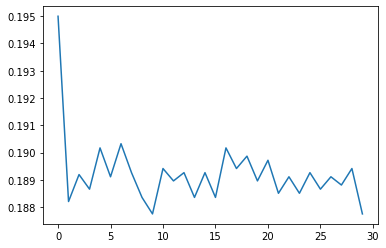

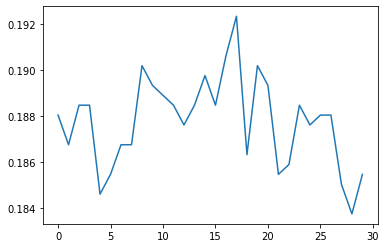

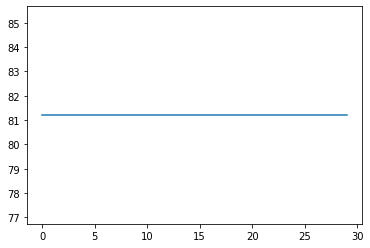

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_ = [loss for loss in train_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in valid_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in acc_epoc]
plt.plot(losses_)
plt.show()


In [13]:
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()
preds = []
sigmoid_fn = torch.nn.Sigmoid()
with torch.no_grad():
    for text in tqdm(test_df["text"].to_list()):
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True, max_length=80).to(device)
        outputs = model(inputs)
        logits = outputs.logits
        
        probs = sigmoid_fn(logits).to('cpu')
        preds.append(probs)

100%|██████████| 2100/2100 [00:25<00:00, 81.95it/s]


In [14]:
correct_cnt = 0
th = 0.4
test_label = test_df["label"].to_list()
for idx in tqdm(range(len(preds))):
    pred = preds[idx]
    predicted = torch.where(pred > th, torch.ones(1, lable_length), torch.zeros(1, lable_length))
    ans_label = torch.tensor(test_label[idx])

    correct_cnt += (predicted == ans_label).sum().item()
    
acc = 100 * correct_cnt / (len(preds)*5)
print(f"Acc: {acc}%")

100%|██████████| 2100/2100 [00:00<00:00, 18254.55it/s]

Acc: 80.80952380952381%


In [15]:
output_info = {
    "train_losses": train_losses,
    "valid_loss": val_loss,
    "eopc_acc": acc_epoc,
}
log_path = path.replace("model", "log").replace(".pth", ".pkl")

import pickle
with open(log_path, 'wb') as f:
  pickle.dump(output_info , f)

log_path

'./log/IzumiElectraModel_multilabel_L1loss.pkl'